In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR

from tqdm import tqdm
from io import StringIO
import sys

%matplotlib inline
import matplotlib.pyplot as plt


In [4]:

# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor()
                                       #transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor()
                                       #transforms.Normalize((0.1307,), (0.3081,))
                                       ])



In [5]:

# Dataset and Creating Train/Test Split

train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)



In [6]:
# Dataloader Arguments & Test/Train Dataloaders

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)


CUDA Available? True


In [5]:
raw_train_data = train.data  

In [10]:
raw_train_data.max(), raw_train_data.min(), raw_train_data.mean()

(np.uint8(255), np.uint8(0), np.float64(120.70756512369792))

torch.Size([128, 3, 32, 32])
torch.Size([128])


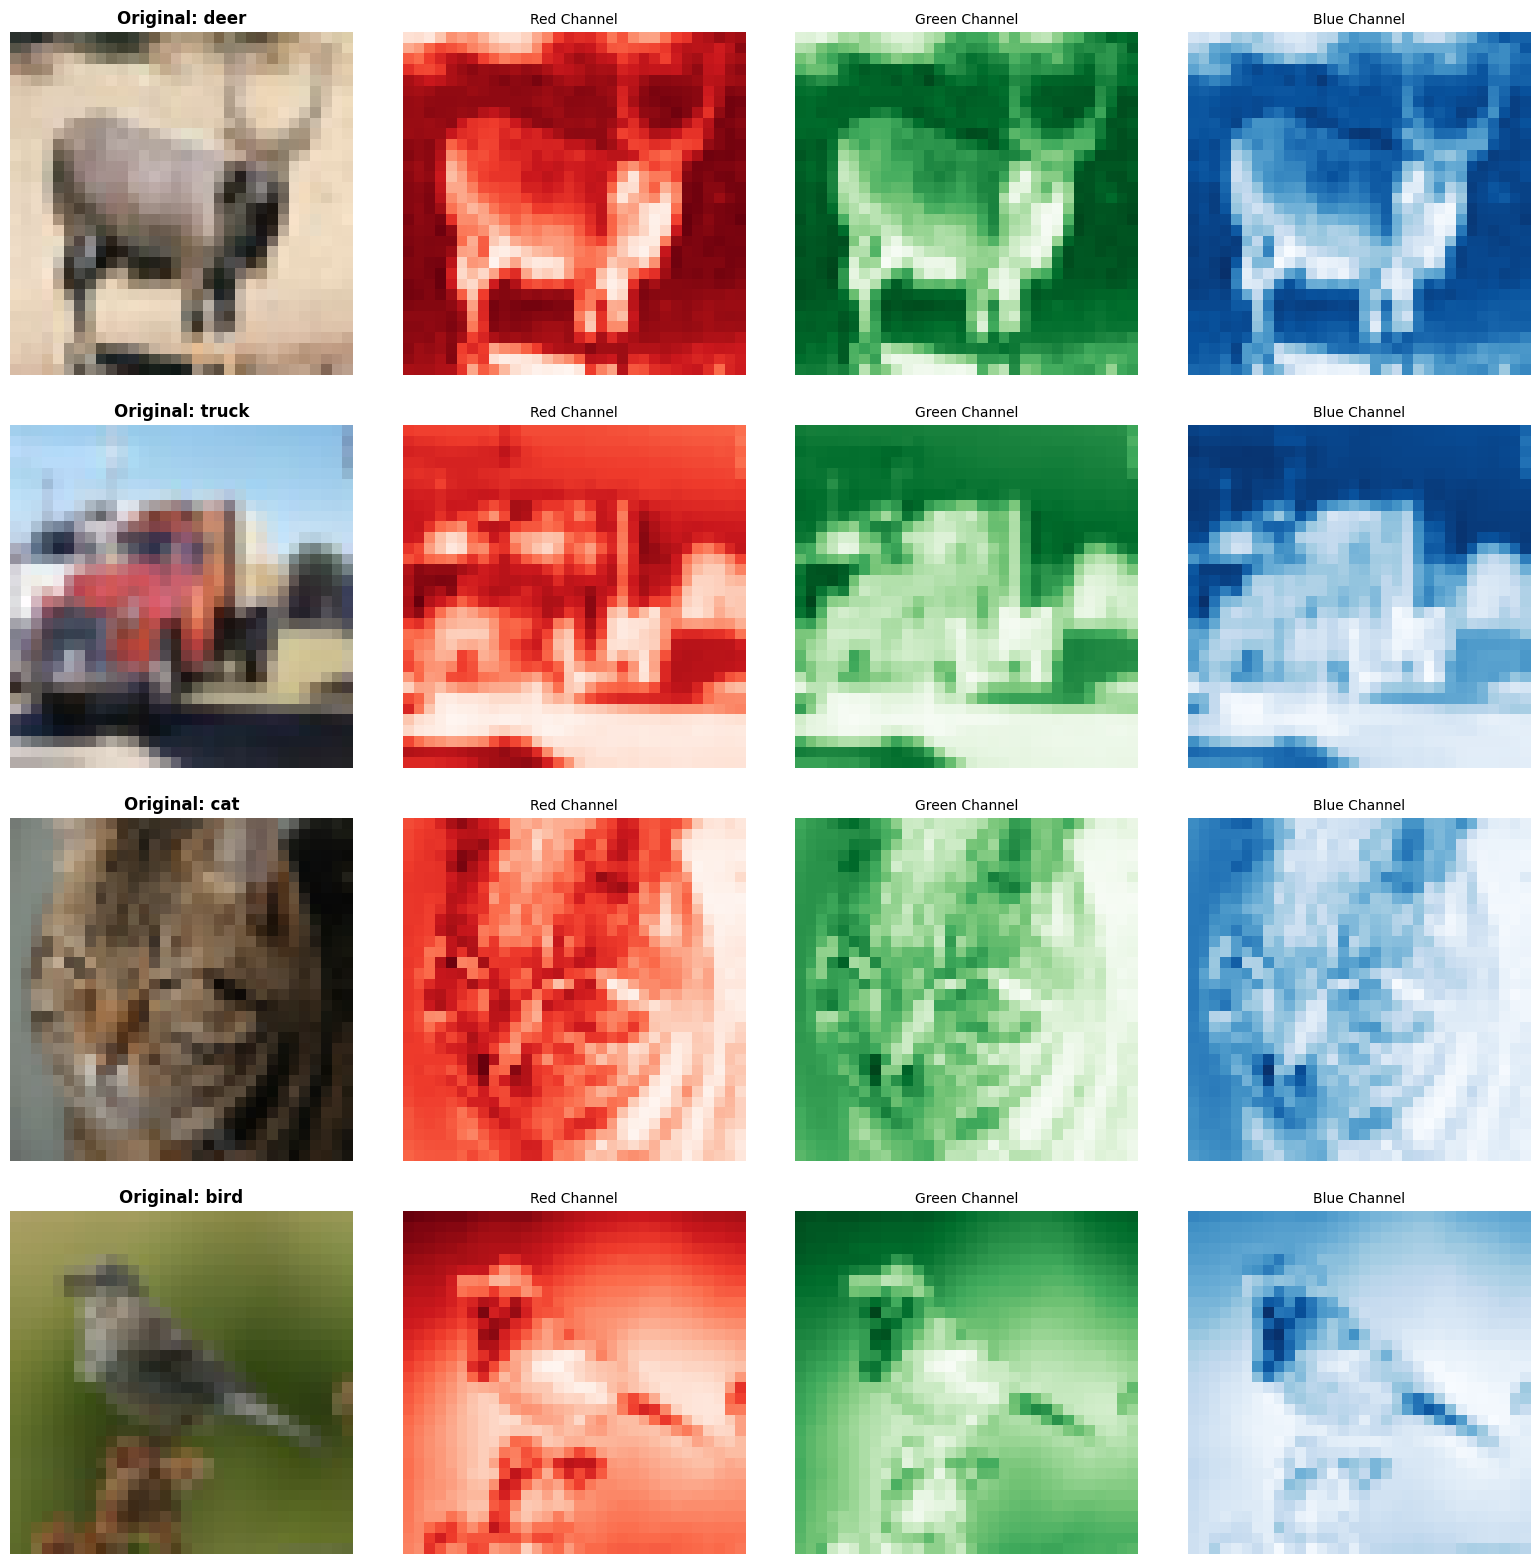

In [83]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

# CIFAR-10 class names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(images.shape)
print(labels.shape)

# Create a 4x4 grid showing 4 samples with their RGB channels
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

for i in range(4):  # Show 4 samples
    img = images[i].permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    
    # Original RGB image
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f'Original: {classes[labels[i]]}', fontsize=12, fontweight='bold')
    axes[i, 0].axis('off')
    
    # Red channel
    axes[i, 1].imshow(img[:,:,0], cmap='Reds')
    axes[i, 1].set_title('Red Channel', fontsize=10)
    axes[i, 1].axis('off')
    
    # Green channel
    axes[i, 2].imshow(img[:,:,1], cmap='Greens')
    axes[i, 2].set_title('Green Channel', fontsize=10)
    axes[i, 2].axis('off')
    
    # Blue channel
    axes[i, 3].imshow(img[:,:,2], cmap='Blues')
    axes[i, 3].set_title('Blue Channel', fontsize=10)
    axes[i, 3].axis('off')

plt.tight_layout(pad=2.0)
plt.show()

Images are of 32x32 resolution with 3 channels - 10 classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

60000 total frames , 50000 Train - 10000 Test set

Hence , we are dealing 500000x32x32 pixel values as input



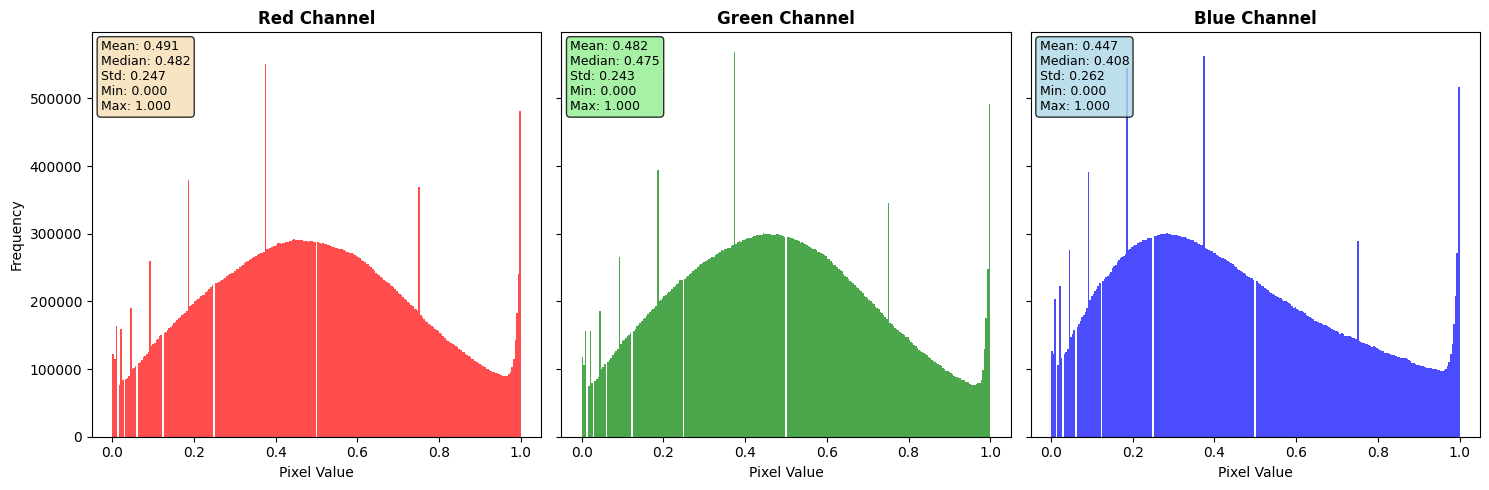

In [108]:
import numpy as np

raw_train_data = raw_train_data.astype(np.float32)  ## mimic the ToTensor() transformation

fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(15, 5))

# Calculate statistics for each channel
red_data = raw_train_data[:,:,:,0].ravel()/255.0
green_data = raw_train_data[:,:,:,1].ravel()/255.0
blue_data = raw_train_data[:,:,:,2].ravel()/255.0

# Red channel
axs[0].hist(red_data, bins=255, color='red', alpha=0.7)
red_stats = f'Mean: {np.mean(red_data):.3f}\nMedian: {np.median(red_data):.3f}\nStd: {np.std(red_data):.3f}\nMin: {np.min(red_data):.3f}\nMax: {np.max(red_data):.3f}'
axs[0].set_title('Red Channel', fontsize=12, fontweight='bold')
axs[0].text(0.02, 0.98, red_stats, transform=axs[0].transAxes, fontsize=9, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
axs[0].set_xlabel('Pixel Value')
axs[0].set_ylabel('Frequency')

# Green channel
axs[1].hist(green_data, bins=255, color='green', alpha=0.7)
green_stats = f'Mean: {np.mean(green_data):.3f}\nMedian: {np.median(green_data):.3f}\nStd: {np.std(green_data):.3f}\nMin: {np.min(green_data):.3f}\nMax: {np.max(green_data):.3f}'
axs[1].set_title('Green Channel', fontsize=12, fontweight='bold')
axs[1].text(0.02, 0.98, green_stats, transform=axs[1].transAxes, fontsize=9, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
axs[1].set_xlabel('Pixel Value')

# Blue channel
axs[2].hist(blue_data, bins=255, color='blue', alpha=0.7)
blue_stats = f'Mean: {np.mean(blue_data):.3f}\nMedian: {np.median(blue_data):.3f}\nStd: {np.std(blue_data):.3f}\nMin: {np.min(blue_data):.3f}\nMax: {np.max(blue_data):.3f}'
axs[2].set_title('Blue Channel', fontsize=12, fontweight='bold')
axs[2].text(0.02, 0.98, blue_stats, transform=axs[2].transAxes, fontsize=9, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
axs[2].set_xlabel('Pixel Value')

plt.tight_layout()
plt.show()

Since there is differences in distribution between RGB channels , It is adviced to apply channel wise image norm

In [109]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
# Convert to PyTorch tensor first, then scale
raw_train_data = train.data  
float_data = torch.tensor(raw_train_data, dtype=torch.float32) / 255.0

print('[Train - Overall]')
print(' - Numpy Shape:', raw_train_data.shape)
print(' - Tensor Shape:', float_data.size())
print(' - min:', torch.min(float_data))
print(' - max:', torch.max(float_data))
print(' - mean:', torch.mean(float_data))
print(' - std:', torch.std(float_data))
print(' - var:', torch.var(float_data))

print('\n[Train - Channel-wise Statistics]')
print('=' * 50)

# Channel-wise statistics
for i, channel in enumerate(['Red', 'Green', 'Blue']):
    channel_data = float_data[:, :, :, i]
    print(f'\n{channel} Channel (Channel {i}):')
    print(f' - Shape: {channel_data.shape}')
    print(f' - Min: {torch.min(channel_data):.6f}')
    print(f' - Max: {torch.max(channel_data):.6f}')
    print(f' - Mean: {torch.mean(channel_data):.6f}')
    print(f' - Median: {torch.median(channel_data):.6f}')
    print(f' - Std: {torch.std(channel_data):.6f}')
    print(f' - Var: {torch.var(channel_data):.6f}')
    print(f' - Range: {torch.max(channel_data) - torch.min(channel_data):.6f}')
    
    # Memory-efficient percentile calculation using numpy
    channel_np = channel_data.numpy()
    print(f' - 25th Percentile: {np.percentile(channel_np, 25):.6f}')
    print(f' - 75th Percentile: {np.percentile(channel_np, 75):.6f}')

# Summary table
print('\n[Summary Table]')
print('=' * 80)
print(f"{'Channel':<8} {'Min':<8} {'Max':<8} {'Mean':<8} {'Median':<8} {'Std':<8} {'Var':<8}")
print('-' * 80)

for i, channel in enumerate(['Red', 'Green', 'Blue']):
    channel_data = float_data[:, :, :, i]
    print(f"{channel:<8} {torch.min(channel_data):.4f} {torch.max(channel_data):.4f} "
          f"{torch.mean(channel_data):.4f} {torch.median(channel_data):.4f} "
          f"{torch.std(channel_data):.4f} {torch.var(channel_data):.4f}")

# Additional insights
print('\n[Additional Insights]')
print('=' * 50)

# Check if data is normalized
red_mean = torch.mean(float_data[:, :, :, 0])
green_mean = torch.mean(float_data[:, :, :, 1])
blue_mean = torch.mean(float_data[:, :, :, 2])

print(f'Red channel mean: {red_mean:.4f}')
print(f'Green channel mean: {green_mean:.4f}')
print(f'Blue channel mean: {blue_mean:.4f}')

# Check for any potential issues
print(f'\nData range check:')
print(f' - All values >= 0: {torch.all(float_data >= 0)}')
print(f' - All values <= 1: {torch.all(float_data <= 1)}')
print(f' - Any NaN values: {torch.any(torch.isnan(float_data))}')
print(f' - Any Inf values: {torch.any(torch.isinf(float_data))}')

# Channel correlation (using a sample for memory efficiency)
print(f'\nChannel correlations (using 10% sample):')
sample_size = len(float_data) // 10  # Use 10% of data
sample_indices = torch.randperm(len(float_data))[:sample_size]
sample_data = float_data[sample_indices]

red_flat = sample_data[:, :, :, 0].flatten()
green_flat = sample_data[:, :, :, 1].flatten()
blue_flat = sample_data[:, :, :, 2].flatten()

print(f' - Red-Green correlation: {torch.corrcoef(torch.stack([red_flat, green_flat]))[0, 1]:.4f}')
print(f' - Red-Blue correlation: {torch.corrcoef(torch.stack([red_flat, blue_flat]))[0, 1]:.4f}')
print(f' - Green-Blue correlation: {torch.corrcoef(torch.stack([green_flat, blue_flat]))[0, 1]:.4f}')

[Train - Overall]
 - Numpy Shape: (50000, 32, 32, 3)
 - Tensor Shape: torch.Size([50000, 32, 32, 3])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.4734)
 - std: tensor(0.2516)
 - var: tensor(0.0633)

[Train - Channel-wise Statistics]

Red Channel (Channel 0):
 - Shape: torch.Size([50000, 32, 32])
 - Min: 0.000000
 - Max: 1.000000
 - Mean: 0.491399
 - Median: 0.482353
 - Std: 0.247032
 - Var: 0.061025
 - Range: 1.000000
 - 25th Percentile: 0.301961
 - 75th Percentile: 0.670588

Green Channel (Channel 1):
 - Shape: torch.Size([50000, 32, 32])
 - Min: 0.000000
 - Max: 1.000000
 - Mean: 0.482158
 - Median: 0.474510
 - Std: 0.243485
 - Var: 0.059285
 - Range: 1.000000
 - 25th Percentile: 0.298039
 - 75th Percentile: 0.654902

Blue Channel (Channel 2):
 - Shape: torch.Size([50000, 32, 32])
 - Min: 0.000000
 - Max: 1.000000
 - Mean: 0.446531
 - Median: 0.407843
 - Std: 0.261588
 - Var: 0.068428
 - Range: 1.000000
 - 25th Percentile: 0.235294
 - 75th Percentile: 0.635294

[Summary Ta

In [7]:
# Cell 1: Import and setup
import sys
import os
sys.path.append('.')

from Data_Manager import DataConfig, CIFAR10DataManager, Logger, Config
import torch
import numpy as np
import matplotlib.pyplot as plt

# Create configuration
config = Config()
config.data.batch_size = 128
config.data.data_dir = './data'

# Create logger
logger = Logger(config.logging)

print("Configuration loaded successfully!")
print(f"Data directory: {config.data.data_dir}")
print(f"Batch size: {config.data.batch_size}")
print(f"CIFAR-10 mean: {config.data.cifar10_mean}")
print(f"CIFAR-10 std: {config.data.cifar10_std}")

2025-10-01 15:22:38,415 - CIFAR-10_Training - INFO - Logger initialized. Log file: c:\Users\krish\Documents\Krishnakanth\Learnings\Learnings\MNIST_Model\Reference\ERAS7\logs\20251001_152238_cifar10_training.log


Configuration loaded successfully!
Data directory: ./data
Batch size: 128
CIFAR-10 mean: (0.4914, 0.4822, 0.4465)
CIFAR-10 std: (0.247, 0.2435, 0.2616)


In [8]:
# Cell 2: Create DataManager and load data
# Create data manager
data_manager = CIFAR10DataManager(config.data, logger)

# Load datasets (this returns datasets, not dataloaders based on your current code)
train_dataset, test_dataset = data_manager.load_data()

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Classes: {data_manager.classes}")

2025-10-01 15:22:40,379 - CIFAR-10_Training - INFO - Loading CIFAR-10 dataset...


Train dataset size: 50000
Test dataset size: 10000
Classes: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [7]:
# Cell 3: Get dataset-level normalized statistics
def get_dataset_normalized_stats(data_manager, batch_size=1000, num_batches=None):
    """
    Get comprehensive statistics from the entire dataset after normalization.
    Uses the DataManager's dataset with transforms applied.
    """
    from torch.utils.data import DataLoader
    
    # Create dataloader from the dataset (which has transforms applied)
    dataloader = DataLoader(
        data_manager.train_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=0
    )
    
    # Initialize accumulators
    all_images = []
    red_channel = []
    green_channel = []
    blue_channel = []
    
    print("Processing dataset for normalized statistics...")
    
    # Process batches
    for i, (images, labels) in enumerate(dataloader):
        if num_batches is not None and i >= num_batches:
            break
            
        if i % 10 == 0:
            print(f"Processed {i} batches...")
        
        # Collect all images (these are already normalized!)
        all_images.append(images)
        
        # Collect channel-wise data
        red_channel.append(images[:, 0, :, :].flatten())
        green_channel.append(images[:, 1, :, :].flatten())
        blue_channel.append(images[:, 2, :, :].flatten())
    
    # Concatenate all data
    all_images = torch.cat(all_images, dim=0)
    red_channel = torch.cat(red_channel, dim=0)
    green_channel = torch.cat(green_channel, dim=0)
    blue_channel = torch.cat(blue_channel, dim=0)
    
    print(f"Total images processed: {len(all_images)}")
    print(f"Image shape: {all_images.shape}")
    
    # Overall statistics
    overall_stats = {
        'shape': all_images.shape,
        'min': torch.min(all_images).item(),
        'max': torch.max(all_images).item(),
        'mean': torch.mean(all_images).item(),
        'std': torch.std(all_images).item(),
        'var': torch.var(all_images).item()
    }
    
    # Channel-wise statistics
    channel_stats = {}
    for i, (channel_name, channel_data) in enumerate([('Red', red_channel), ('Green', green_channel), ('Blue', blue_channel)]):
        channel_stats[channel_name.lower()] = {
            'min': torch.min(channel_data).item(),
            'max': torch.max(channel_data).item(),
            'mean': torch.mean(channel_data).item(),
            'median': torch.median(channel_data).item(),
            'std': torch.std(channel_data).item(),
            'var': torch.var(channel_data).item(),
            'range': (torch.max(channel_data) - torch.min(channel_data)).item()
        }
    
    return {
        'overall': overall_stats,
        'channels': channel_stats,
        'all_images': all_images,
        'red_channel': red_channel,
        'green_channel': green_channel,
        'blue_channel': blue_channel
    }

# Get normalized statistics for training dataset
print("Getting normalized statistics for training dataset...")
train_stats = get_dataset_normalized_stats(data_manager, batch_size=1000, num_batches=50)  # Process 50 batches (50k images)

print("\n" + "="*60)
print("NORMALIZED DATASET STATISTICS (Training Set)")
print("="*60)

# Overall statistics
print(f"Overall Statistics:")
print(f"  - Shape: {train_stats['overall']['shape']}")
print(f"  - Min: {train_stats['overall']['min']:.6f}")
print(f"  - Max: {train_stats['overall']['max']:.6f}")
print(f"  - Mean: {train_stats['overall']['mean']:.6f}")
print(f"  - Std: {train_stats['overall']['std']:.6f}")
print(f"  - Var: {train_stats['overall']['var']:.6f}")

print(f"\nChannel-wise Statistics:")
for channel, stats in train_stats['channels'].items():
    print(f"\n{channel.capitalize()} Channel:")
    print(f"  - Min: {stats['min']:.6f}")
    print(f"  - Max: {stats['max']:.6f}")
    print(f"  - Mean: {stats['mean']:.6f}")
    print(f"  - Median: {stats['median']:.6f}")
    print(f"  - Std: {stats['std']:.6f}")
    print(f"  - Var: {stats['var']:.6f}")
    print(f"  - Range: {stats['range']:.6f}")

Getting normalized statistics for training dataset...
Processing dataset for normalized statistics...
Processed 0 batches...
Processed 10 batches...
Processed 20 batches...
Processed 30 batches...
Processed 40 batches...
Total images processed: 50000
Image shape: torch.Size([50000, 3, 32, 32])

NORMALIZED DATASET STATISTICS (Training Set)
Overall Statistics:
  - Shape: torch.Size([50000, 3, 32, 32])
  - Min: -1.989474
  - Max: 2.126489
  - Mean: -0.000018
  - Std: 1.000008
  - Var: 1.000015

Channel-wise Statistics:

Red Channel:
  - Min: -1.989474
  - Max: 2.059109
  - Mean: -0.000001
  - Median: -0.036628
  - Std: 1.000131
  - Var: 1.000261
  - Range: 4.048583

Green Channel:
  - Min: -1.980288
  - Max: 2.126489
  - Mean: -0.000171
  - Median: -0.031582
  - Std: 0.999939
  - Var: 0.999878
  - Range: 4.106776

Blue Channel:
  - Min: -1.706804
  - Max: 2.115826
  - Mean: 0.000118
  - Median: -0.147771
  - Std: 0.999954
  - Var: 0.999907
  - Range: 3.822630


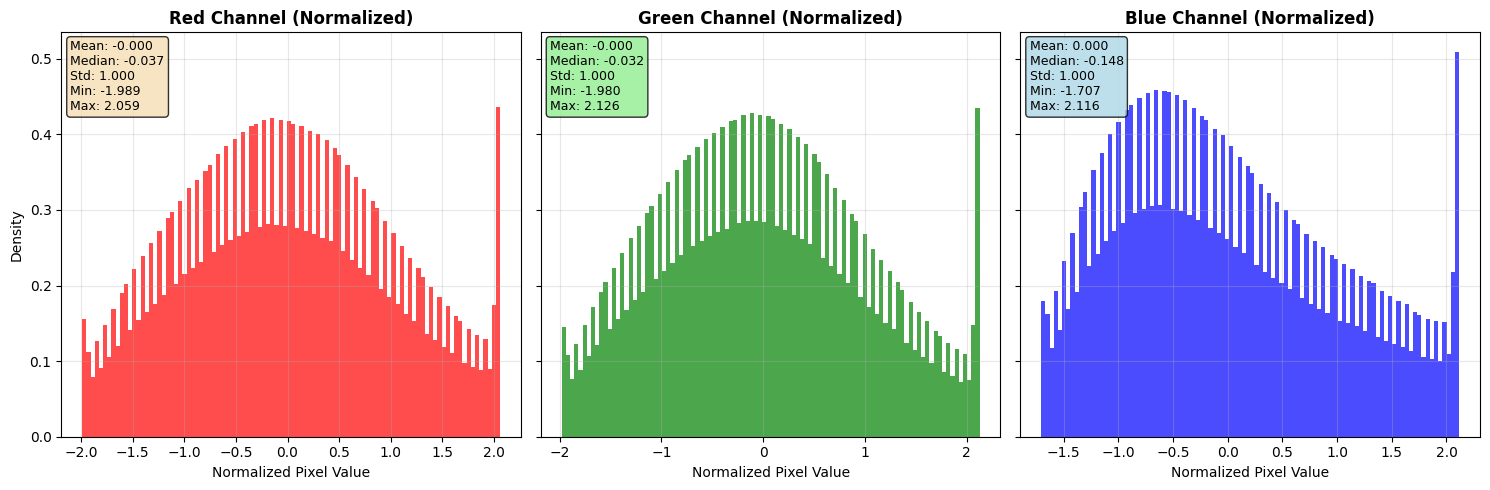

In [8]:
# Cell 4: Plot normalized channel histograms
def plot_normalized_histograms(stats, save_path=None):
    """Plot histograms for normalized data."""
    fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(15, 5))
    
    # Get channel data
    red_data = stats['red_channel']
    green_data = stats['green_channel']
    blue_data = stats['blue_channel']
    
    # Red channel
    axs[0].hist(red_data.numpy(), bins=100, color='red', alpha=0.7, density=True)
    red_stats_text = f'Mean: {torch.mean(red_data):.3f}\nMedian: {torch.median(red_data):.3f}\nStd: {torch.std(red_data):.3f}\nMin: {torch.min(red_data):.3f}\nMax: {torch.max(red_data):.3f}'
    axs[0].set_title('Red Channel (Normalized)', fontsize=12, fontweight='bold')
    axs[0].text(0.02, 0.98, red_stats_text, transform=axs[0].transAxes, fontsize=9, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    axs[0].set_xlabel('Normalized Pixel Value')
    axs[0].set_ylabel('Density')
    axs[0].grid(True, alpha=0.3)
    
    # Green channel
    axs[1].hist(green_data.numpy(), bins=100, color='green', alpha=0.7, density=True)
    green_stats_text = f'Mean: {torch.mean(green_data):.3f}\nMedian: {torch.median(green_data):.3f}\nStd: {torch.std(green_data):.3f}\nMin: {torch.min(green_data):.3f}\nMax: {torch.max(green_data):.3f}'
    axs[1].set_title('Green Channel (Normalized)', fontsize=12, fontweight='bold')
    axs[1].text(0.02, 0.98, green_stats_text, transform=axs[1].transAxes, fontsize=9, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    axs[1].set_xlabel('Normalized Pixel Value')
    axs[1].grid(True, alpha=0.3)
    
    # Blue channel
    axs[2].hist(blue_data.numpy(), bins=100, color='blue', alpha=0.7, density=True)
    blue_stats_text = f'Mean: {torch.mean(blue_data):.3f}\nMedian: {torch.median(blue_data):.3f}\nStd: {torch.std(blue_data):.3f}\nMin: {torch.min(blue_data):.3f}\nMax: {torch.max(blue_data):.3f}'
    axs[2].set_title('Blue Channel (Normalized)', fontsize=12, fontweight='bold')
    axs[2].text(0.02, 0.98, blue_stats_text, transform=axs[2].transAxes, fontsize=9, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    axs[2].set_xlabel('Normalized Pixel Value')
    axs[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Normalized histograms saved to: {save_path}")
    
    plt.show()

# Plot the normalized histograms
plot_normalized_histograms(train_stats)

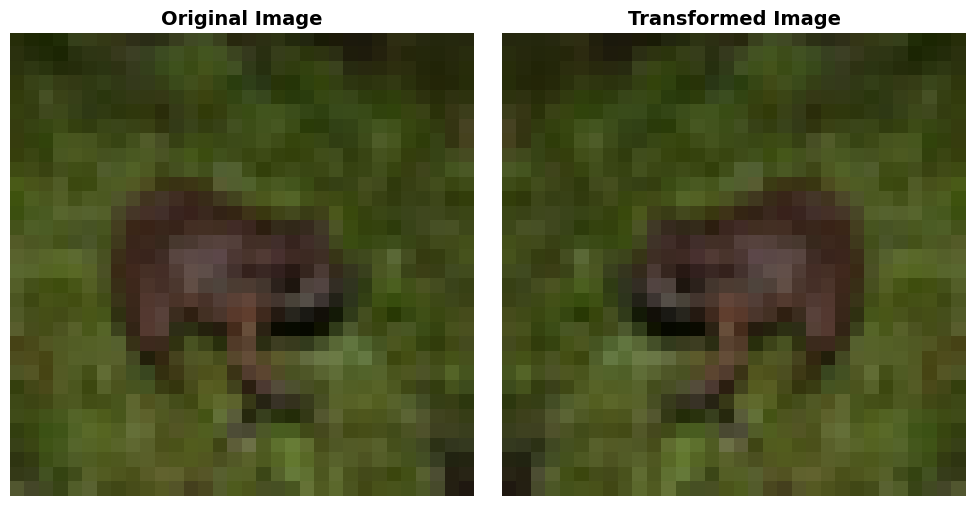

In [48]:
import torch
import torchvision.transforms.functional as TF
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from random import randint
import albumentations as albu

def visualize_transformed_images (image , flipped_image):

    # Visualize both images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Original image
    axes[0].imshow(image)
    axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
    axes[0].axis('off')

    # Flipped image
    axes[1].imshow(flipped_image)
    axes[1].set_title('Transformed Image', fontsize=14, fontweight='bold')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

random_Image_index = randint(0,50000)

# Get the original image (numpy array)
image = data_manager.train_dataset.data[random_Image_index]

# # Convert to PIL Image (PyTorch transforms work with PIL Images)
# pil_image = Image.fromarray(image)

# # Horizontally flip using PyTorch functional API
# flipped_pil = TF.hflip(pil_image)

transform =albu.HorizontalFlip(p=0.5)
augmented_image = transform(image=image)['image']

# Convert back to numpy for visualization
flipped_image = np.array(augmented_image)

visualize_transformed_images(image ,flipped_image)


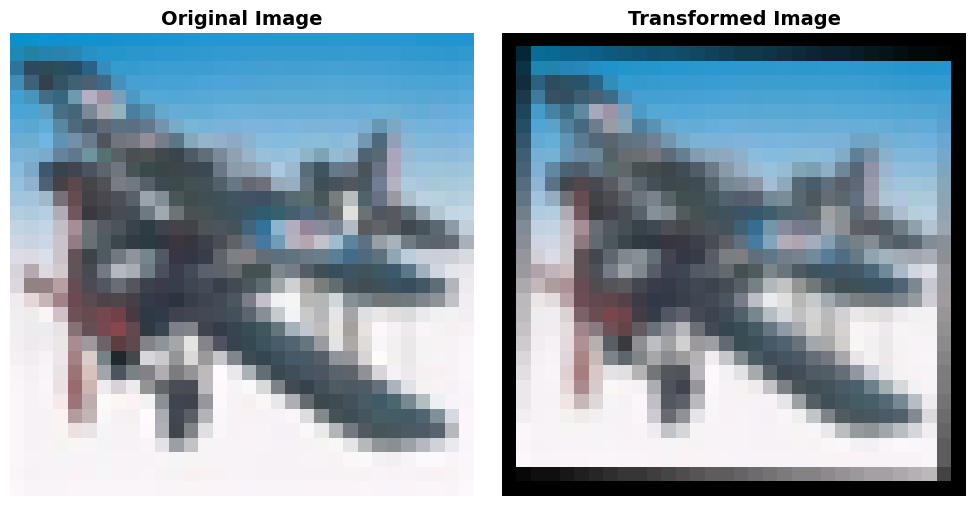

In [50]:
random_Image_index = randint(0,50000)

# Get the original image (numpy array)
image = data_manager.train_dataset.data[random_Image_index]

transform = albu.augmentations.geometric.transforms.ShiftScaleRotate(shift_limit = 0.01, scale_limit = 0.1, rotate_limit = 15)
augmented_image = transform(image=image)['image']
# Convert back to numpy for visualization
flipped_image = np.array(augmented_image)

visualize_transformed_images(image ,flipped_image)

C:\Users\krish\AppData\Local\Temp\ipykernel_1852\399224445.py:5: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value, mask_fill_value, always_apply' are not valid for transform CoarseDropout
  transform = albu.CoarseDropout(max_holes = 1, # Maximum number of regions to zero out. (default: 8)


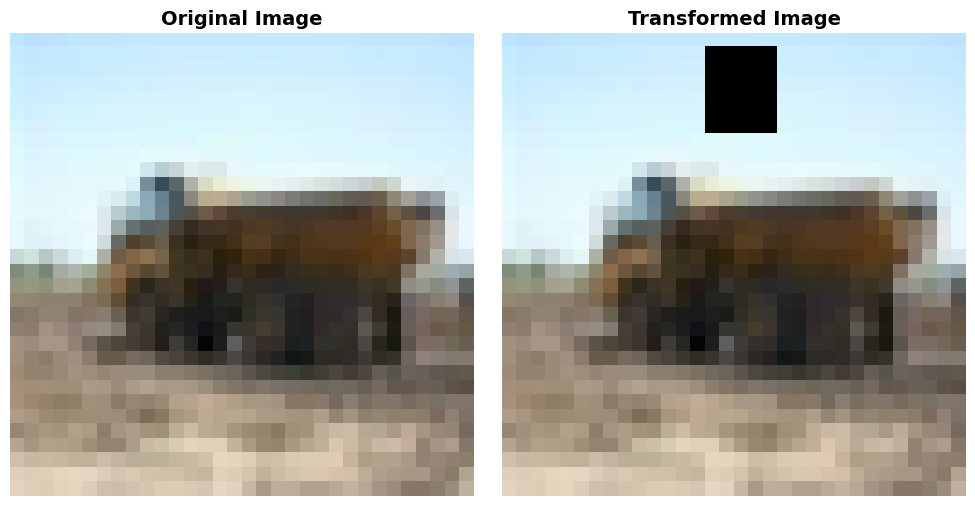

In [56]:
random_Image_index = randint(0,50000)

# Get the original image (numpy array)
image = data_manager.train_dataset.data[random_Image_index]
transform = albu.CoarseDropout(max_holes = 1, # Maximum number of regions to zero out. (default: 8)
                    max_height = 16, # Maximum height of the hole. (default: 8) 
                    max_width = 16, # Maximum width of the hole. (default: 8) 
                    min_holes=1, # Maximum number of regions to zero out. (default: None, which equals max_holes)
                    min_height=16, # Maximum height of the hole. (default: None, which equals max_height)
                    min_width=16, # Maximum width of the hole. (default: None, which equals max_width)
                    fill_value=(125, 123, 114), # value for dropped pixels.
                    mask_fill_value=None, # fill value for dropped pixels in mask. 
                    always_apply=False
                   )
augmented_image = transform(image=image)['image']
# Convert back to numpy for visualization
flipped_image = np.array(augmented_image)

visualize_transformed_images(image ,flipped_image)
